In [2]:
from netCDF4 import Dataset
import numpy as np
import os
from glob import glob
import datetime as dt
from netCDF4 import date2num,num2date
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr

import ppigrf
import datetime as dt 

In [3]:
time_ref=dt.datetime(2023,2,21)
event_key=time_ref.strftime("%Y%m%d")
model_type = ['/normal/','/ashley/']
type_str = ['FAC-driven', 'Ashley']

model_choice = 0

if model_choice == 0:
    type_m = type_str[0]
    model = model_type[0]
elif model_choice == 1:
    type_m = type_str[1]
    model = model_type[1]

print ("Working on:",event_key)


home_pt='/glade/work/prasoonv/gitm/3DYNAMO/3dall/'   
data_pt=home_pt+event_key+model+'/outputs/3dall_final/'

save_pt=data_pt
if not os.path.exists(save_pt):                                            
    os.makedirs(save_pt)     

fname=data_pt+'combined_parms_3dall.npz'

data=np.load(fname)
for key in data.files:
    print(f"Key: {key},", f"Shape: {data[key].shape}")
    #print(f"Data Type: {data[key].dtype}")
    #print(f"Sample Data: {data[key][:5]}")  # Print the first 5 elements
    #print("="*50)
dimensions=["ut","glon","glat","alt"]

gitm_time_ref=time_ref + dt.timedelta(days=1)
ut=data['ut']
ut=[(dt.timedelta(hours=(i-ut[0])) + gitm_time_ref) for i in ut]

ds = xr.Dataset(
    coords={'ut':ut,
            'glon':data['glon'],
            'glat':data['glat'],
            'alt':data['alt']})
for key in data.files[4:]:
    ds[key]=(('ut','glon','glat','alt'),data[key])    
print(ds)


Working on: 20230221
Key: ut, Shape: (433,)
Key: glon, Shape: (72,)
Key: glat, Shape: (72,)
Key: alt, Shape: (50,)
Key: Un, Shape: (433, 72, 72, 50)
Key: Vn, Shape: (433, 72, 72, 50)
Key: SigP, Shape: (433, 72, 72, 50)
Key: SigH, Shape: (433, 72, 72, 50)
<xarray.Dataset> Size: 4GB
Dimensions:  (ut: 433, glon: 72, glat: 72, alt: 50)
Coordinates:
  * ut       (ut) datetime64[ns] 3kB 2023-02-22 ... 2023-02-24T23:59:57
  * glon     (glon) float64 576B 2.5 7.5 12.5 17.5 ... 342.5 347.5 352.5 357.5
  * glat     (glat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * alt      (alt) float64 400B 100.0 101.7 103.3 105.0 ... 559.8 575.6 591.4
Data variables:
    Un       (ut, glon, glat, alt) float64 898MB -1.145 -1.84 ... 27.55 27.49
    Vn       (ut, glon, glat, alt) float64 898MB 4.648 -7.926 ... -328.8 -329.0
    SigP     (ut, glon, glat, alt) float64 898MB 2.931e-06 ... 4.32e-10
    SigH     (ut, glon, glat, alt) float64 898MB 7.308e-05 ... 2.963e-15


In [4]:
file_gitm = data_pt + 'gic_201503.nc'
ds_gitm = xr.open_dataset(file_gitm)
ds_gitm = ds_gitm.assign_coords(
    mlat=("mlat", ds_gitm.mlat_gitm.values),
    mlon=("mlon", ds_gitm.mlon_gitm.values),
    lat=("lat", ds_gitm.glat_gitm.values),
    lon=("lon",ds_gitm.glon_gitm.values),
    alt=("alt",ds_gitm.alt_gitm.values),
    time=("time",ds_gitm.time_gitm.values)
)
ds_gitm = ds_gitm.drop_vars(["mlat_gitm", "mlon_gitm", "time_gitm", "glat_gitm", "glon_gitm", "alt_gitm"])
print(ds_gitm)
print()

ef_gitm = ds_gitm.sel(mlat=0, mlon=7.62, method='nearest')
# above is point where 65W longitude cuts the magnetic equator
ef_only = ef_gitm.ed2_gitm

/glade/derecho/scratch/prasoonv/tmp/ipykernel_94186/2386371035.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_gitm = xr.open_dataset(file_gitm)


<xarray.Dataset> Size: 4GB
Dimensions:       (mlat: 161, mlon: 100, time: 433, alt: 50, lat: 72, lon: 72)
Coordinates:
  * mlat          (mlat) float64 1kB -90.0 -86.95 -83.9 ... 83.9 86.95 90.0
  * mlon          (mlon) float64 800B -180.0 -176.4 -172.8 ... 169.2 172.8 176.4
  * lat           (lat) float32 288B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon           (lon) float32 288B 2.5 7.5 12.5 17.5 ... 347.5 352.5 357.5
  * alt           (alt) float32 200B 100.0 101.7 103.3 ... 559.8 575.6 591.4
  * time          (time) timedelta64[ns] 3kB -756 days +00:00:02.999999992 .....
Data variables:
    poten2d_gitm  (mlat, mlon, time) float64 56MB ...
    ed2_gitm      (mlat, mlon, time) float64 56MB ...
    un_gitm       (alt, lat, lon, time) float64 898MB ...
    vn_gitm       (alt, lat, lon, time) float64 898MB ...
    sigP_gitm     (alt, lat, lon, time) float64 898MB ...
    sigH_gitm     (alt, lat, lon, time) float64 898MB ...
Attributes:
    title:    GITM inputs for 3Dynamo



[Timestamp('2023-02-22 00:00:00'), Timestamp('2023-02-22 00:09:57.000000016'), Timestamp('2023-02-22 00:19:57'), Timestamp('2023-02-22 00:29:58.000000008'), Timestamp('2023-02-22 00:39:58.000000008'), Timestamp('2023-02-22 00:49:58'), Timestamp('2023-02-22 00:59:57.000000008'), Timestamp('2023-02-22 01:09:57.000000016'), Timestamp('2023-02-22 01:19:58'), Timestamp('2023-02-22 01:29:57.000000008'), Timestamp('2023-02-22 01:39:59.000000008'), Timestamp('2023-02-22 01:49:57'), Timestamp('2023-02-22 01:59:57.000000008'), Timestamp('2023-02-22 02:09:58.000000008'), Timestamp('2023-02-22 02:19:58'), Timestamp('2023-02-22 02:29:57.000000008'), Timestamp('2023-02-22 02:39:57.000000016'), Timestamp('2023-02-22 02:49:57'), Timestamp('2023-02-22 02:59:57.000000008'), Timestamp('2023-02-22 03:09:59.000000008'), Timestamp('2023-02-22 03:19:57'), Timestamp('2023-02-22 03:29:58.000000008'), Timestamp('2023-02-22 03:39:57.000000016'), Timestamp('2023-02-22 03:49:57'), Timestamp('2023-02-22 03:59:57.00

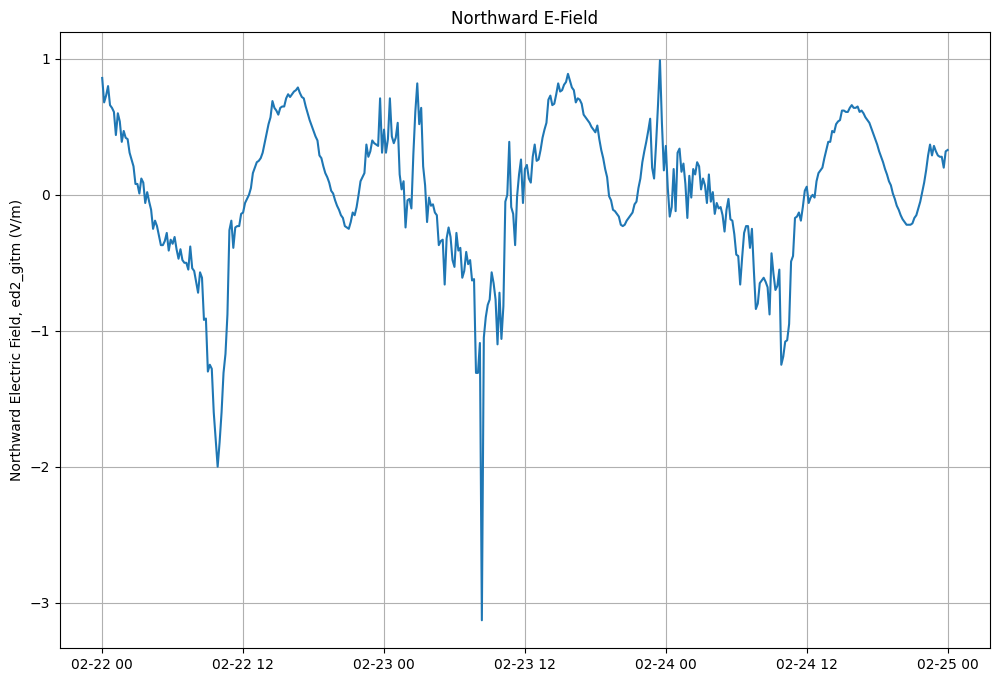

In [5]:
# Here this is the description of variables in data -
# poten2d - Electric potential (V), ed2_gitm - Northward electric field (V/m)
# Un - Zonal wind (m/s), Vn - Meridional wind (m/s), sigP - Pedersen conductivity (S/m)
# sigH - Hall conductivity (S/m) 

time = ef_gitm.time.values
start_time = pd.Timestamp("2023-02-22 00:00:00")
time_0 = time[0]
time = [start_time + pd.to_timedelta(i-time_0, unit='ns') for i in time]
print(time)


plt.figure(figsize=(12,8))
plt.plot(time, ef_gitm.ed2_gitm)
plt.title('Northward E-Field')
plt.ylabel('Northward Electric Field, ed2_gitm (V/m)')
plt.grid()

In [6]:
ds_dynamo = xr.open_dataset(data_pt + 'final_dynamo_result.nc')


print(ds_dynamo.data_vars)

/glade/derecho/scratch/prasoonv/tmp/ipykernel_94186/2066784031.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_dynamo = xr.open_dataset(data_pt + 'final_dynamo_result.nc')


Data variables:
    year      (time) float64 3kB ...
    doy       (time) float64 3kB ...
    f107      (time) float64 3kB ...
    ap        (time) float64 3kB ...
    ut        (time) timedelta64[ns] 3kB ...
    ctpoten   (time) float64 3kB ...
    hpower    (time) float64 3kB ...
    Jf1       (time, hgt, lat_qd, lon_qd) float64 5GB ...
    Jf2       (time, hgt, lat_qd, lon_qd) float64 5GB ...
    Jr        (time, hgt, lat_qd, lon_qd) float64 5GB ...
    Jfac      (time, hgt, lat_qd, lon_qd) float64 5GB ...
    Jf1hor    (time, hgt, lat_qd, lon_qd) float64 5GB ...
    Jf2hor    (time, hgt, lat_qd, lon_qd) float64 5GB ...
    un_s1     (time, fldpts_qdlat1, mlon1) float64 3GB ...
    vn_s1     (time, fldpts_qdlat1, mlon1) float64 3GB ...
    sigH_s1   (time, fldpts_qdlat1, mlon1) float64 3GB ...
    sigP_s1   (time, fldpts_qdlat1, mlon1) float64 3GB ...
    sinI_s1   (time, fldpts_qdlat1, mlon1) float64 3GB ...
    sinI_s2   (time, fldpts_qdlat2, mlon2) float64 3GB ...
    Je1D      (

<xarray.Dataset> Size: 76GB
Dimensions:        (time: 433, mlon2: 120, lon_qd: 120, mlat2: 180,
                    lat_qd: 220, mlat3qd: 182, hgt: 54, hgt_r: 55,
                    fldpts_qdlat1: 6966, fldpts_hgt1: 6966,
                    fldpts_qdlat2: 6858, fldpts_hgt2: 6858,
                    fldpts_qdlat3: 7040, fldpts_hgt3: 7040,
                    fldpts_qdlatp: 6966, fldpts_hgtp: 6966, glon: 119,
                    glat: 179, ghgt: 55, ghgtB: 55, glon_sph: 120,
                    glat_sph: 180, hgtTop_sph: 54, hgt_sph: 54)
Coordinates: (12/26)
  * time           (time) float64 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    mlon1          float64 8B 7.5
  * mlon2          (mlon2) float64 960B -180.0 -177.0 -174.0 ... 174.0 177.0
  * lon_qd         (lon_qd) float64 960B -180.0 -177.0 -174.0 ... 174.0 177.0
    mlat1          float64 8B -0.7626
  * mlat2          (mlat2) float64 1kB -88.91 -86.73 -84.54 ... 86.73 88.91
    ...             ...
  * ghgt           (ghgt) flo

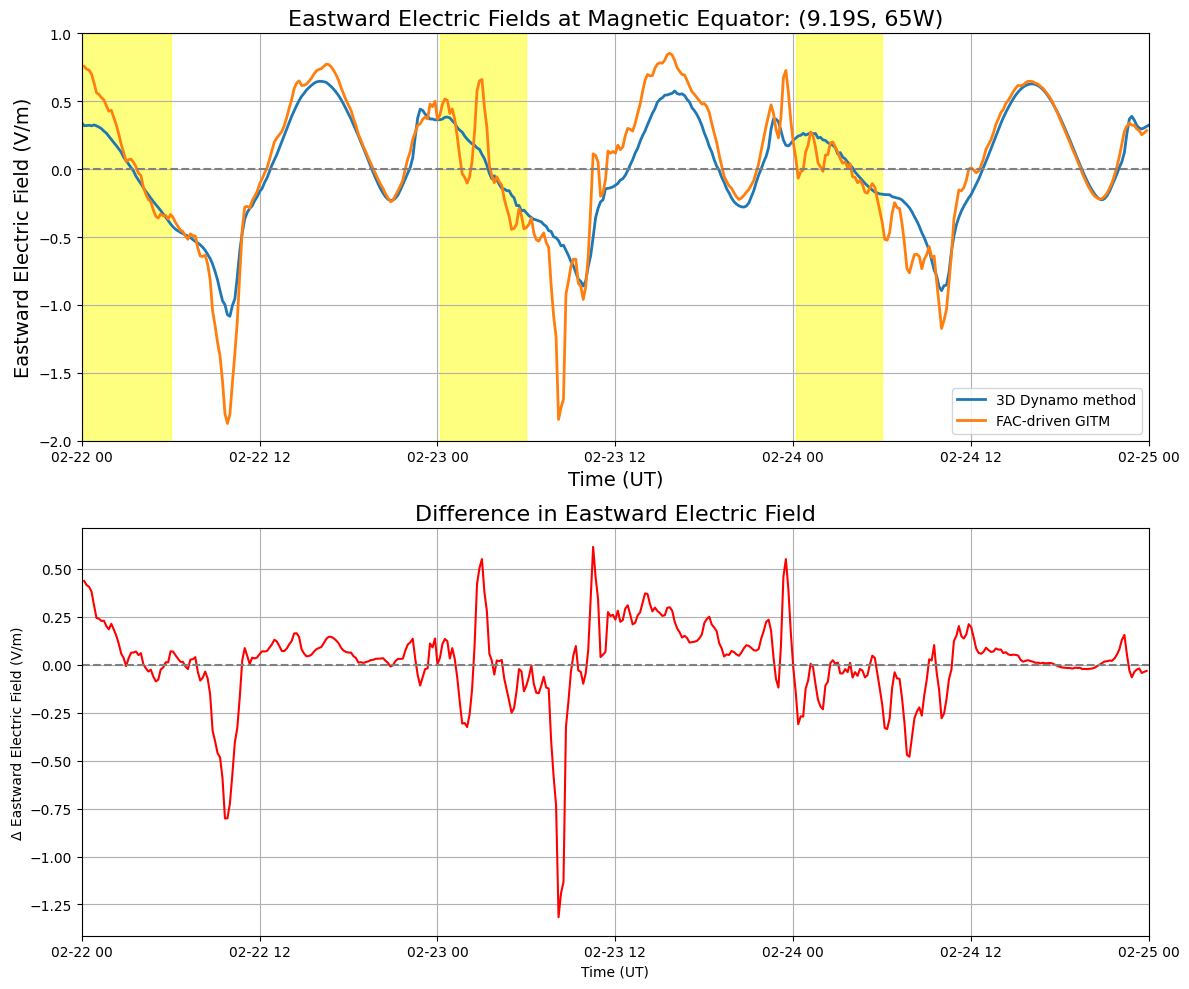

In [7]:
e_field = ds_dynamo

#print(e_field)
#print(e_field.time.values)

ef_dynamo = e_field.sel(mlat1=0, mlon1=7.62, method='nearest')
# magnetic equator (0,7.62) will be at glat=9.19S, glon=65.16W
ef_dynamo['ExB_smooth'] = ef_dynamo['Ed1_S1'].rolling(time=3, center=True).mean()

ef = [i*1000 for i in ef_dynamo.Ed1_S1.values]

#print(ds_gitm.Ed2_S1.values)
print(ef_dynamo)

t = list(range(len(ds_dynamo.time.values)))

e_gitm = ef_gitm.ed2_gitm.rolling(time=3, center=True).mean()
del_ef = [i-j for i,j in zip(e_gitm.values, ef)]

# Create a figure with two rows of subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))#, sharex=True)

start_time = pd.to_datetime("2023-02-22 00:00:00")
day2_time = pd.to_datetime("2023-02-23 00:00:00")
day3_time = pd.to_datetime("2023-02-24 00:00:00")
end_time = pd.to_datetime("2023-02-25 00:00:00")

# First subplot: Eastward Electric Field Comparison
axs[0].plot(time, ef, label='3D Dynamo method', linewidth=2)
axs[0].plot(time, e_gitm.values, label='FAC-driven GITM', linewidth=2)
# below is the point where same 65W longitude cuts magnetic equator 
axs[0].set_title('Eastward Electric Fields at Magnetic Equator: (9.19S, 65W)', fontsize=16)
axs[0].set_ylabel('Eastward Electric Field (V/m)',fontsize=14)
axs[0].set_xlabel('Time (UT)', fontsize=14)
axs[0].legend()
axs[0].grid()
axs[0].set_xlim(start_time, end_time)
axs[0].axhline(0, color='gray', linestyle='--')
axs[0].set_ylim(-2,1)

# Second subplot: Difference in Eastward Electric Field
axs[1].plot(time, del_ef, color='r')
axs[1].set_title('Difference in Eastward Electric Field',fontsize=16)
axs[1].set_ylabel('Δ Eastward Electric Field (V/m)')
axs[1].set_xlabel('Time (UT)')
axs[1].grid()
axs[1].set_xlim(start_time, end_time)
axs[1].axhline(0, color='gray', linestyle='--') 

time = pd.Series(time)
# Adjust layout
axs[0].fill_between(time, -2, 1, 
                 where=((time >= start_time) & (time <= pd.to_datetime('2023-02-22 06:00:00')) | 
                        (time >= day2_time) & (time <= pd.to_datetime('2023-02-23 06:00:00')) |
                        (time >= day3_time) & (time <= pd.to_datetime('2023-02-24 06:00:00')) 
                        ),
                 color='yellow',
                 alpha=0.5
                 )
plt.tight_layout()
plt.show()


In [8]:
file = '/glade/work/prasoonv/scratch/bz_ey_dst_values_5min.txt'
params = pd.read_csv(file,delim_whitespace=True)
#print(params.columns)

time_p = [start_time + pd.Timedelta(minutes=5*i) for i in range(len(params['Year']))]
params['Time'] = time_p
params = params[params['Ey'] < 200]
params['Bz_mean'] = params['Bz'].rolling(window=12).mean()
print(params)

     Year  DOY  Hour  Min    By    Bz    Ey  SYMH                Time  \
0    2023   53     0    0  6.27  0.38 -0.15   -11 2023-02-22 00:00:00   
1    2023   53     0    5  6.88 -1.23  0.46   -11 2023-02-22 00:05:00   
2    2023   53     0   10  7.07 -0.38  0.21   -11 2023-02-22 00:10:00   
3    2023   53     0   15  8.48  0.35 -0.11   -10 2023-02-22 00:15:00   
4    2023   53     0   20  8.45  0.40 -0.32    -9 2023-02-22 00:20:00   
..    ...  ...   ...  ...   ...   ...   ...   ...                 ...   
834  2023   55    21   30  0.10  4.66 -2.10    -5 2023-02-24 21:30:00   
835  2023   55    21   35  0.11  4.66 -2.09    -6 2023-02-24 21:35:00   
836  2023   55    21   40  0.12  4.64 -2.08    -6 2023-02-24 21:40:00   
837  2023   55    21   45  0.13  4.64 -2.06    -6 2023-02-24 21:45:00   
838  2023   55    21   50  0.01  4.52 -2.06    -6 2023-02-24 21:50:00   

      Bz_mean  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
..        ...  
834  4.5225

/glade/derecho/scratch/prasoonv/tmp/ipykernel_94186/3381416334.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  params = pd.read_csv(file,delim_whitespace=True)


[21573.05305418]
21742.435279905716


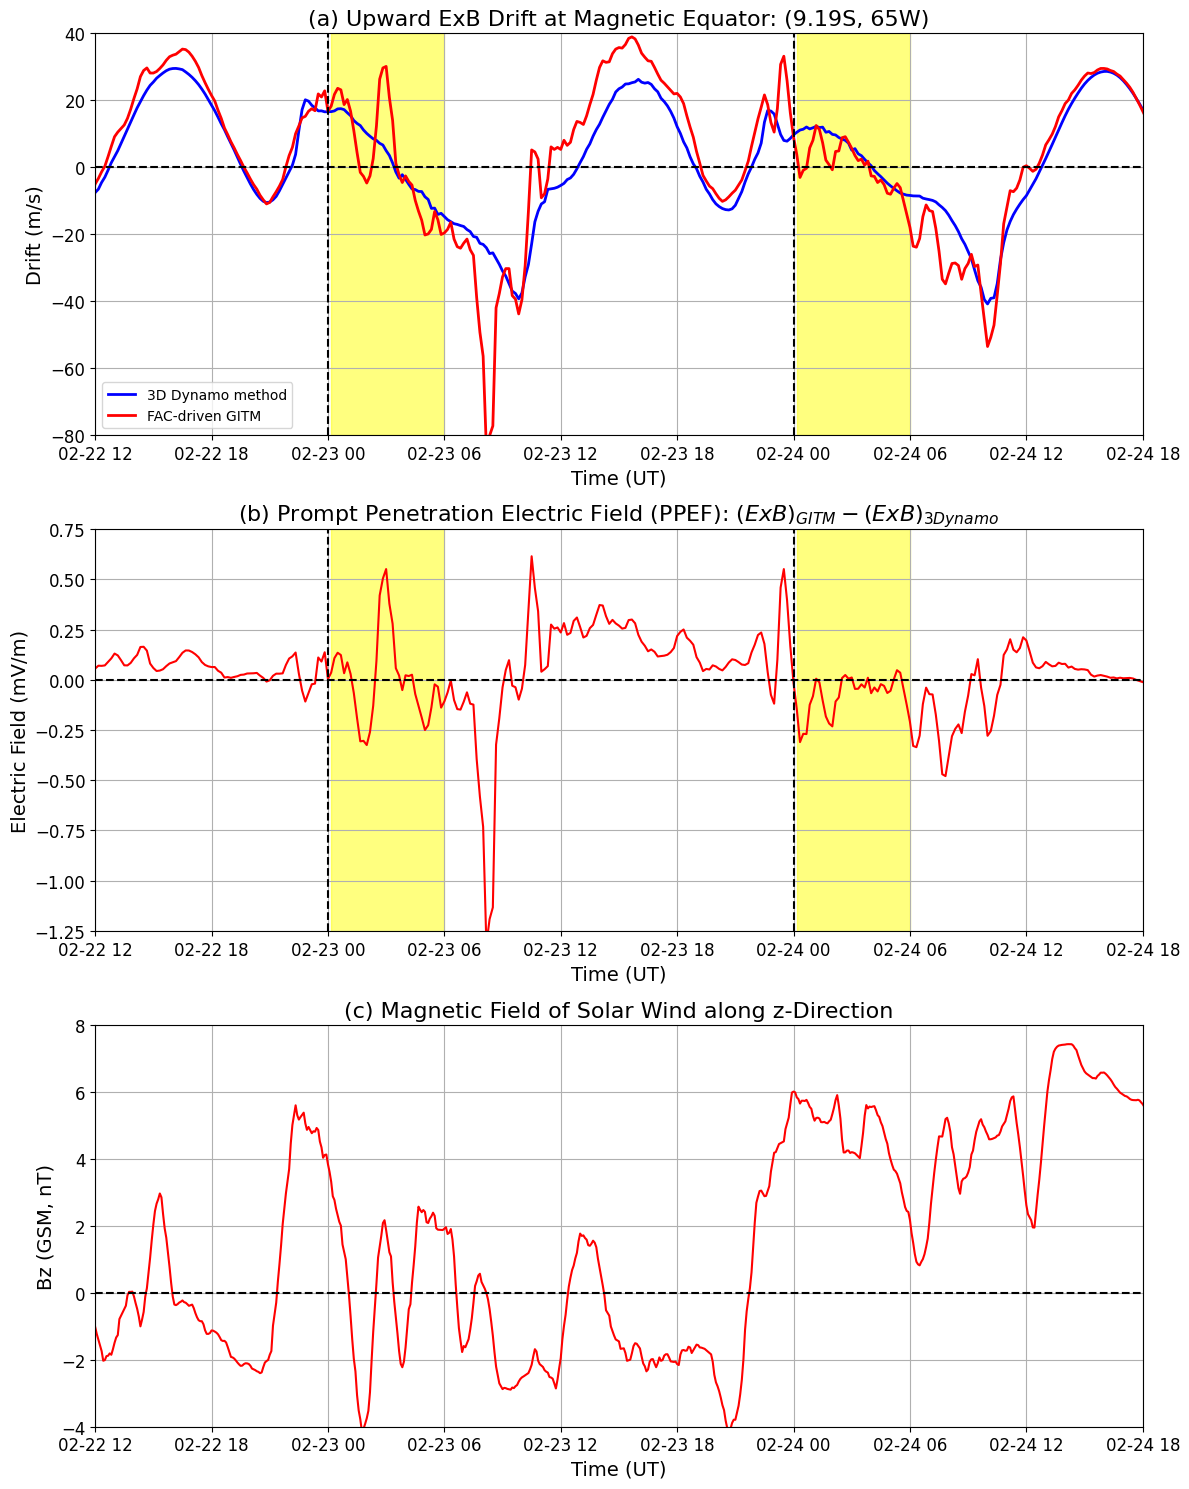

In [ ]:
# Beast, Bnorth, Bup = ppigrf.igrf(lon, lat, h, date)

Be,Bn,Bu = ppigrf.igrf(-72.7,-9.27,300,dt.datetime(2023,3,23))
print(Bn)
B_tot = (Bn[0]**2 + Be[0]**2 + Bu[0]**2)**0.5
print(B_tot)


exb_dynamo = [i*10**6*Bn[0]/B_tot**2 for i in ef]
exb_gitm = [i*10**6*Bn[0]/B_tot**2 for i in e_gitm.values]


# Create a figure with two rows of subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 15))#, sharex=True)

start_time = pd.to_datetime("2023-02-22 12:00:00")
day2_time = pd.to_datetime("2023-02-23 00:00:00")
day3_time = pd.to_datetime("2023-02-24 00:00:00")
end_time = pd.to_datetime("2023-02-24 18:00:00")

# First subplot: Eastward Electric Field Comparison
axs[0].plot(time, exb_dynamo, label='3D Dynamo method', linewidth=2,color='blue')
axs[0].plot(time, exb_gitm, label='FAC-driven GITM', linewidth=2, color='red')
axs[0].set_title('(a) Upward ExB Drift at Magnetic Equator: (9.19S, 65W)', fontsize=16)
axs[0].set_ylabel('Drift (m/s)',fontsize=14)
axs[0].set_xlabel('Time (UT)', fontsize=14)
axs[0].legend()
axs[0].grid()
axs[0].set_xlim(start_time, end_time)
axs[0].axhline(0, color='black', linestyle='--')
axs[0].axvline(day2_time, color='black', linestyle='--')
axs[0].axvline(day3_time, color='black', linestyle='--')
axs[0].set_ylim(-80,40)
axs[0].tick_params(axis='both', labelsize=12)

del_exb = [(i-j)*B_tot**2/(10**6*Bn[0]) for i,j in zip(exb_gitm, exb_dynamo)]

# Second subplot: Difference in Eastward Electric Field
axs[1].plot(time, del_exb, color='red')
axs[1].set_title(r'(b) Prompt Penetration Electric Field (PPEF): $(ExB)_{GITM}-(ExB)_{3Dynamo}$', fontsize=16)
axs[1].set_ylabel('Electric Field (mV/m)', fontsize=14)
axs[1].set_xlabel('Time (UT)', fontsize=14)
axs[1].grid()
axs[1].set_xlim(start_time, end_time)
axs[1].axhline(0, color='black', linestyle='--') 
axs[1].axvline(day2_time, color='black', linestyle='--')
axs[1].axvline(day3_time, color='black', linestyle='--')
axs[1].set_ylim(-1.25,0.75)
axs[1].tick_params(axis='both', labelsize=12)

time = pd.Series(time)

# Third subplot: Bz and Ey values
axs[2].plot(params.Time, params.Bz_mean, label='Bz (nT) - OMNI data', color='red')
#axs[2].plot(params.Time, params.Ey, label='Ey (mV/m) - OMNI data', color='blue')
axs[2].grid()
axs[2].set_xlabel('Time (UT)', fontsize=14)
axs[2].set_ylabel('Bz (GSM, nT)', fontsize=14)
axs[2].set_title('(c) Magnetic Field of Solar Wind along z-Direction', fontsize=16)
axs[2].set_ylim(-4,8)
axs[2].set_xlim(start_time, end_time)
axs[2].axhline(0, color='black', linestyle='--')
axs[2].tick_params(axis='both',labelsize=12)

# Adjust layout
axs[0].fill_between(time, -80, 40, 
                 where=((time >= start_time) & (time <= pd.to_datetime('2023-02-22 06:00:00')) | 
                        (time >= day2_time) & (time <= pd.to_datetime('2023-02-23 06:00:00')) |
                        (time >= day3_time) & (time <= pd.to_datetime('2023-02-24 06:00:00')) 
                        ),
                 color='yellow',
                 alpha=0.5
                 )
axs[1].fill_between(time, -80, 40, 
                 where=((time >= start_time) & (time <= pd.to_datetime('2023-02-22 06:00:00')) | 
                        (time >= day2_time) & (time <= pd.to_datetime('2023-02-23 06:00:00')) |
                        (time >= day3_time) & (time <= pd.to_datetime('2023-02-24 06:00:00')) 
                        ),
                 color='yellow',
                 alpha=0.5
                 )
plt.tight_layout()
plt.show()

plt.savefig(f'{save_pt}ppef_exbdrift.jpg', bbox_inches='tight', pad_inches=0)